

# 1. Context, Objectives and Research Questions

-------------------- 


## Context
This project analyzes a dataset of reviews from a password management app on the Google Play Store. The objective is to use modern Natural Language Processing (NLP) techniques to extract deep insights about user experience.

## Objective
Use a Transformer model to automatically classify Google Play reviews by functionality.
Identify the app's strengths and weaknesses by analyzing the average satisfaction score for each category.

## Research Questions
1. **What are the Strengths?** Which app features have the highest average satisfaction (Rating)?
2. **What are the Critical Points (Bottlenecks)?** Which features are receiving the worst ratings (Ratings 1 and 2)?
3. **Community Validation:** Is there a positive correlation between high-rated reviews and the number of likes (`thumbs_up`) received?

```

Expected example for transformer model usage: The phrase "I changed phones and lost everything" is classified as "Backup" by the model, even without the word backup. The Transformer understands the context, unlike simple keyword searches. This ensures that real and serious problems are detected correctly.

## Setup & Preparation

In [27]:
!pip install transformers torch pandas matplotlib seaborn scikit-learn


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline
from tqdm import tqdm
import warnings


## Load the dataset

The data was obtained from the Kaggle dataset: https://www.kaggle.com/datasets/muqaddasejaz/google-play-app-reviews-dataset/data

In [29]:
df = pd.read_csv('../data/GooglePlay_App_Data.csv') #read the file
df.head()

,review_id,user_name,review_title,review_description,rating,thumbs_up,review_date,developer_response,developer_response_date,appVersion,laguage_code,country_code
0,81942ead-9d65-4b1a-8aa2-6e21ad5cf5e7,Vernalee Fortin,NaN,"Still loving it!, the best!",5,0,9/3/2024 0:23,NaN,NaN,23.12.04000,en,us
1,c08cf1e7-45e4-43a3-b86f-51f7809b80a3,Toki Doki,NaN,Convenient one stop app for all your passwords...,5,0,8/19/2024 3:32,NaN,NaN,23.12.04000,en,us
2,c8937763-e1b4-43b1-9e48-cde58be80111,CJ Cross,NaN,Tried several password managers until I came a...,5,0,7/30/2024 8:07,NaN,NaN,23.12.04000,en,us
3,762baf4b-9109-4b4b-a42f-2291b0486faf,Trevor Lewis,NaN,Ok thank you,5,0,6/11/2024 17:20,NaN,NaN,NaN,en,us
4,275a2d36-6d77-44ae-9d7b-8be6ad614e3f,K K,NaN,switched phones and none of my passwords came ...,1,0,5/19/2024 19:20,You have to do a backup on Google Drive / Drop...,5/21/2024 23:50,23.12.04000,en,us


In [30]:
df.columns

Index(['review_id', 'user_name', 'review_title', 'review_description',
       'rating', 'thumbs_up', 'review_date', 'developer_response',
       'developer_response_date', 'appVersion', 'laguage_code',
       'country_code'],
      dtype='object')


We can see that our dataset has several columns, each with a specific role in our analysis:

*   **Identification:** `review_id`, `user_name`, `review_title`.
*   **Review description (`review_description`):** Main text column, **important for the Transformer**.
*   **Rating (`rating`):** The rating given by the user, **important for correlation analysis**.
*   **Engagement (`thumbs_up`):** Number of likes on the review, **important to know how many people agree with the user's analysis**.
*   **Timeline and Support:** `review_date` (review date), `developer_response` (development team response) and `developer_response_date` (**important to know the team's response speed**).
*   **Context:** `appVersion` (app version), `language_code` (review language) and `country_code` (user country).


In [31]:
df.isna().sum() 

review_id                    0
user_name                    0
review_title               161
review_description           0
rating                       0
thumbs_up                    0
review_date                  0
developer_response         111
developer_response_date    111
appVersion                  15
laguage_code                 0
country_code                 0
dtype: int64

The analysis indicates missing data in review_title and responses, but this does not impact the project since the essential review_description column is complete. The cleaning is minimal and consists only of filling empty titles with an empty string (''), avoiding errors when processing the text for the model.

This must be done because I intend to combine titles with descriptions to facilitate transformer model analysis

# 2. Data Cleaning

----------

In [32]:
df['review_title']= df['review_title'].replace(np.nan, '') #replace null data with empty string
#stores in the original column, now without null data.
#Replace(Old_Value, New_Value)
df.head()

,review_id,user_name,review_title,review_description,rating,thumbs_up,review_date,developer_response,developer_response_date,appVersion,laguage_code,country_code
0,81942ead-9d65-4b1a-8aa2-6e21ad5cf5e7,Vernalee Fortin,,"Still loving it!, the best!",5,0,9/3/2024 0:23,NaN,NaN,23.12.04000,en,us
1,c08cf1e7-45e4-43a3-b86f-51f7809b80a3,Toki Doki,,Convenient one stop app for all your passwords...,5,0,8/19/2024 3:32,NaN,NaN,23.12.04000,en,us
2,c8937763-e1b4-43b1-9e48-cde58be80111,CJ Cross,,Tried several password managers until I came a...,5,0,7/30/2024 8:07,NaN,NaN,23.12.04000,en,us
3,762baf4b-9109-4b4b-a42f-2291b0486faf,Trevor Lewis,,Ok thank you,5,0,6/11/2024 17:20,NaN,NaN,NaN,en,us
4,275a2d36-6d77-44ae-9d7b-8be6ad614e3f,K K,,switched phones and none of my passwords came ...,1,0,5/19/2024 19:20,You have to do a backup on Google Drive / Drop...,5/21/2024 23:50,23.12.04000,en,us


In [33]:
df.isnull().sum()

review_id                    0
user_name                    0
review_title                 0
review_description           0
rating                       0
thumbs_up                    0
review_date                  0
developer_response         111
developer_response_date    111
appVersion                  15
laguage_code                 0
country_code                 0
dtype: int64

- We now see that there is no null data in the review title column

# 3. Exploratory Data Analysis

------------

## Distribution of Ratings

- First let's analyze the distribution of Ratings to see the current health status of the app. 

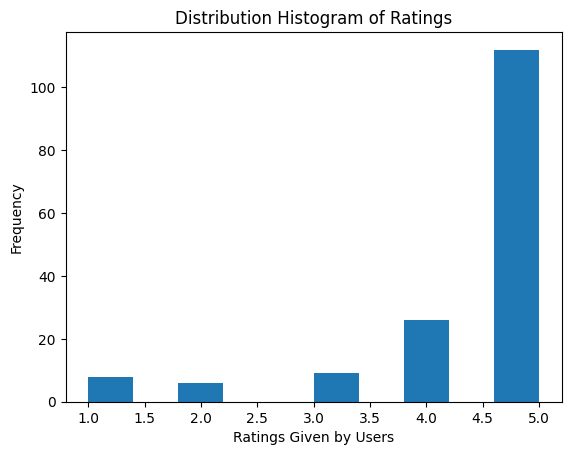

In [34]:
app_ratings = df['rating'] #variable that will store the app ratings

plt.hist(app_ratings) #plot histogram
plt.xlabel('Ratings Given by Users')
plt.ylabel('Frequency')
plt.title('Distribution Histogram of Ratings')
plt.show()


In [35]:
app_ratings.value_counts()

rating
5    112
4     26
3      9
1      8
2      6
Name: count, dtype: int64

The chart demonstrates extremely high satisfaction, with the vast majority of reviews concentrated at the maximum rating (5) and very few low ratings. This indicates very positive acceptance by users regarding the evaluated item. 

Regarding the sum of values for each rating, we see that rating 5 is still much higher than rating 4 and others.

## Correlation between Ratings and Number of Likes per Review

To analyze this correlation, I will use a scatter plot. The objective is to verify if the community agrees with the reported criticisms. For example, a 1-star review with many likes suggests a critical bug affecting multiple users. If there are few likes, it is likely an isolated error from just one user

Text(0.5, 1.0, 'Scatter: Age vs Ratings')

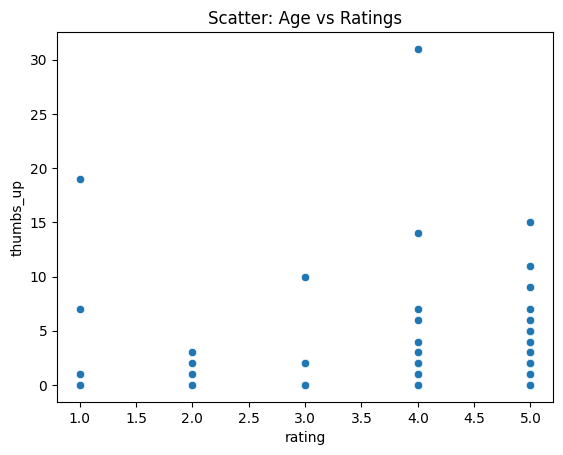

In [36]:
review_likes = df['thumbs_up']

sns.scatterplot(data = df, x = app_ratings , y= review_likes) #x-axis being the ratings and y-axis being the likes on reviews

plt.title("Scatter: Age vs Ratings")

- The scatter plot analysis reveals that, although the application is predominantly well-rated, there are specific situations of strong community agreement: an isolated point at the minimum rating (1 star) with a high number of likes stands out, suggesting a critical bug reported and confirmed by multiple users, while a comment at rating 4 with even greater engagement points to a consensus about relevant feedback or less severe failure that, despite being notable, does not compromise the overall positive satisfaction with the product.

## Analysis by App Version

Identify unstable versions with higher incidence of critical bugs and map the most stable and well-rated updates by the community.

In [37]:
versions = df['appVersion']
app_ratings.groupby(versions).mean()#Groups app_ratings BY versions and calculate the average

appVersion
10.3.1         5.000000
10.4.1         5.000000
10.5.0         5.000000
10.5.1         5.000000
10.5.3         5.000000
16.0.2         4.650000
17.0.0         4.666667
18.0.0         4.543478
22.11.23001    3.714286
22.12.18000    5.000000
22.12.24000    4.333333
23.02.25000    4.700000
23.08.27000    5.000000
23.09.15000    2.500000
23.12.04000    4.400000
4              4.500000
7.0.0          4.400000
7.0.1          3.400000
7.1.1          4.166667
Name: rating, dtype: float64

We see that the most recent versions (22 and 23) have lower average ratings, while older and intermediate versions, such as those in the 10 series, have excellent ratings.

## Text Length vs. Rating

This analysis aims to understand if there is a correlation between text length and the assigned rating. The hypothesis is that dissatisfied users tend to write longer comments to detail problems, while satisfied users tend to be concise (e.g., 'Very good'). Let's verify if this pattern is confirmed in this dataset.

In [38]:
df['text_length'] = df['review_description'].astype(str).apply(len) #check the length
#astype(str) is just to protect if there is any empty field or one that is not recognized as text to be converted
df

,review_id,user_name,review_title,review_description,rating,thumbs_up,review_date,developer_response,developer_response_date,appVersion,laguage_code,country_code,text_length
0,81942ead-9d65-4b1a-8aa2-6e21ad5cf5e7,Vernalee Fortin,,"Still loving it!, the best!",5,0,9/3/2024 0:23,NaN,NaN,23.12.04000,en,us,27
1,c08cf1e7-45e4-43a3-b86f-51f7809b80a3,Toki Doki,,Convenient one stop app for all your passwords...,5,0,8/19/2024 3:32,NaN,NaN,23.12.04000,en,us,189
2,c8937763-e1b4-43b1-9e48-cde58be80111,CJ Cross,,Tried several password managers until I came a...,5,0,7/30/2024 8:07,NaN,NaN,23.12.04000,en,us,272
3,762baf4b-9109-4b4b-a42f-2291b0486faf,Trevor Lewis,,Ok thank you,5,0,6/11/2024 17:20,NaN,NaN,NaN,en,us,12
4,275a2d36-6d77-44ae-9d7b-8be6ad614e3f,K K,,switched phones and none of my passwords came ...,1,0,5/19/2024 19:20,You have to do a backup on Google Drive / Drop...,5/21/2024 23:50,23.12.04000,en,us,76
...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,518e0b64-dcfe-4862-814f-319ac079b68e,A Google user,,Simple but effective,5,0,9/12/2016 22:01,NaN,NaN,4,en,us,20
157,5dcd42c0-64a0-4c1c-9d30-0d90845a3705,A Google user,,I like the recognizable icons for identifying ...,4,0,9/10/2016 0:49,NaN,NaN,4,en,us,64
158,ab0b106b-cacb-4e54-9ab8-63cba5d15574,A Google user,,Colorful and pleasing to the eye. Very simple...,5,5,9/4/2016 5:09,NaN,NaN,4,en,us,179
159,1094d763-3d6a-4d53-9ceb-219627306efe,A Google user,,Love it,5,1,9/1/2016 20:45,NaN,NaN,4,en,us,7


Text(0.5, 1.0, 'Boxplot correlation text length and ratings')

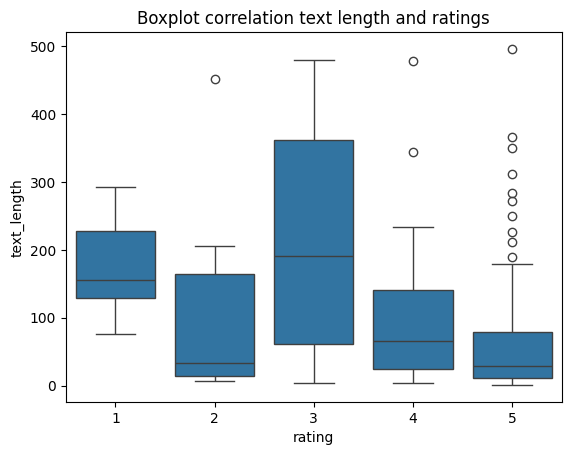

In [39]:
text_length = df['text_length']
sns.boxplot(data=df, x= app_ratings, y=text_length) #plot boxplot

plt.title('Boxplot correlation text length and ratings')

In [40]:
text_length.groupby(app_ratings).mean() #to see the average word length for each

rating
1    174.125000
2    123.666667
3    221.666667
4     99.576923
5     64.964286
Name: text_length, dtype: float64

The hypothesis was partially confirmed, as dissatisfied users (rating 1) write almost triple (average 174) compared to satisfied users (rating 5, average 65), proving that happiness generates more direct comments. However, the pattern is broken by rating 3, which has the longest texts of all (221 characters), indicating that neutral reviews require more elaboration to balance pros and cons.

## Evolution of Ratings Over Time

Shows whether the app is improving or worsening over time. You can see if there was a "complaint spike" on a specific date (when a bug was released).

C:\Users\Jonas\AppData\Local\Temp\ipykernel_10608\1404566480.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_average = df_temporal['rating'].resample('M').mean() #find the average rating per month


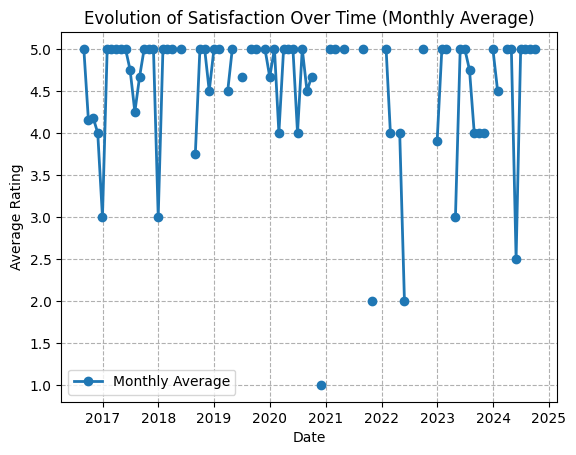

In [41]:
df['review_date'] = pd.to_datetime(df['review_date']) #converts dates to pandas datetime type
df = df.sort_values('review_date')

df_temporal = df.set_index('review_date')# Set date as index (required for resample)
monthly_average = df_temporal['rating'].resample('M').mean() #find the average rating per month

plt.plot(monthly_average.index, monthly_average.values, marker='o', linewidth=2, markersize=6, color='#1f77b4', label='Monthly Average')

plt.title('Evolution of Satisfaction Over Time (Monthly Average)')
plt.xlabel('Date')
plt.ylabel('Average Rating')
plt.grid(True, linestyle='--')
plt.legend()

The chart reveals a consistency of excellence (ceiling of 5 stars), interrupted only by sharp drops indicating specific critical failures on specific dates (likely update bugs). However, the immediate recovery after each decline demonstrates that the team fixes problems quickly, returning the app to the maximum satisfaction level.

# 4. Creating Full Text Features

--------

- Here I will create our features to help with model analysis.

In [42]:
df['full_text'] = df['review_title'] + df['review_description'] #full text with title plus description
df['full_text_length'] = df['full_text'].apply(len) # can be useful for quick checks

df.head()

,review_id,user_name,review_title,review_description,rating,thumbs_up,review_date,developer_response,developer_response_date,appVersion,laguage_code,country_code,text_length,full_text,full_text_length
160,b454b56c-6171-49bb-a04b-b878095b83e2,A Google user,,Awesome,5,1,2016-08-31 06:53:00,NaN,NaN,NaN,en,us,7,Awesome,7
159,1094d763-3d6a-4d53-9ceb-219627306efe,A Google user,,Love it,5,1,2016-09-01 20:45:00,NaN,NaN,4,en,us,7,Love it,7
158,ab0b106b-cacb-4e54-9ab8-63cba5d15574,A Google user,,Colorful and pleasing to the eye. Very simple...,5,5,2016-09-04 05:09:00,NaN,NaN,4,en,us,179,Colorful and pleasing to the eye. Very simple...,179
157,5dcd42c0-64a0-4c1c-9d30-0d90845a3705,A Google user,,I like the recognizable icons for identifying ...,4,0,2016-09-10 00:49:00,NaN,NaN,4,en,us,64,I like the recognizable icons for identifying ...,64
156,518e0b64-dcfe-4862-814f-319ac079b68e,A Google user,,Simple but effective,5,0,2016-09-12 22:01:00,NaN,NaN,4,en,us,20,Simple but effective,20


In [43]:
print("Example of pre-processed data:")
display(df[['full_text', 'rating']].head(3))

Example of pre-processed data:


,full_text,rating
160,Awesome,5
159,Love it,5
158,Colorful and pleasing to the eye. Very simple...,5


# 5. Implementing the Model

-------

- The initial implementation step consists of defining the classification categories (labels). The superiority of the Transformer model lies in its ability to interpret semantic context instead of just searching for keywords. For example, the phrase 'I changed phones and lost everything' is correctly classified as 'Backup', even without the explicit presence of the term. This ensures that critical problems are detected with high precision.

## Model Loading

In [44]:
labels = [
    "Backup and Restore",        # For: Backup and Restore
    "Interface and Usability",   # For: Interface and Usability
    "Security and Access",       # For: Security and Access
    "Support and Response",      # For: Support and Response
    "Data Synchronization"       # For: Data Synchronization
]

-  Model definition: We are instantiating the facebook/bart-large-mnli model directly from the Transformers library through the pipeline function, which downloads and configures everything automatically for immediate use. It comes fully pre-trained, allowing you to classify texts into new categories (Zero-Shot) without needing to teach or train anything from scratch.

In [45]:
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

Loading weights:   0%|          | 0/515 [00:00<?, ?it/s]

![Fluxograma do Modelo](../images/model_flow.jpg)

Below, we present the logical architecture of the BART-MNLI model, demonstrating how it transforms phrases and labels into classification predictions:

![Fluxograma bert](../images/bert_model.jpg)

## Classification Function

In [46]:
def classify_text(text):
    result = classifier(text, labels) #model inputs
    return result['labels'][0], result['scores'][0]

## Apply Model

In [47]:
tqdm.pandas() #observe progress
#tqdm library responsible for creating progress bars
# "injects" the progress_apply() method into pandas

input_text = df['full_text']
#Applies classification to the column with full review texts
#from the function above it will return classified_category (which label it belongs to) and also the probability
results = input_text.progress_apply(classify_text)
#progress_apply applies the function to each row of the column 
df['classified_category'] = [x[0] for x in results] #new column with categories classified by the model
df['Highest_probability'] = [x[1] for x in results] #classification probability


100%|██████████| 161/161 [04:27<00:00,  1.66s/it]


## Visualize Created Columns 

In [48]:
df[['full_text', 'classified_category', 'Highest_probability']].head(20)

,full_text,classified_category,Highest_probability
160,Awesome,Support and Response,0.434154
159,Love it,Support and Response,0.448991
158,Colorful and pleasing to the eye. Very simple...,Interface and Usability,0.596300
157,I like the recognizable icons for identifying ...,Interface and Usability,0.375865
156,Simple but effective,Support and Response,0.338973
155,Looks good so far,Support and Response,0.328439
154,This app is simple and visually pleasing. It a...,Interface and Usability,0.815999
153,This app doesn't need even a single permission.,Security and Access,0.343909
152,Simple and cute. I like that we can add a pass...,Security and Access,0.664436
151,When I downloaded this app my expectation was ...,Interface and Usability,0.332270


# 6. Results

----------

In [49]:
# Grouping by Category and calculating statistics
category_stats = df.groupby('classified_category').agg({#metrics by category
    'rating': ['mean', 'count'],#average and count of ratings 
    'thumbs_up': 'sum', #votes on comments
    'Highest_probability':'mean' #average classification probability
}).round(2)

# Adjusting column names
category_stats.columns = ['Average_Rating', 'Review_Count', 'Total_Likes', 'Category_Average_Probability']
category_stats = category_stats.sort_values(by='Average_Rating', ascending=True)
print(category_stats)

                         Average_Rating  Review_Count  Total_Likes  \
classified_category                                                  
Backup and Restore                 3.25             4           36   
Security and Access                3.94            36           89   
Interface and Usability            4.58            64          120   
Support and Response               4.61            56           69   
Data Synchronization               5.00             1            0   

                         Category_Average_Probability  
classified_category                                    
Backup and Restore                               0.40  
Security and Access                              0.56  
Interface and Usability                          0.47  
Support and Response                             0.38  
Data Synchronization                             0.29  


- To test the model's accuracy, let's choose 5 random texts and see what a human would classify and what was actually classified.

In [50]:
import pandas as pd

# Filter only reviews with ratings from 1 to 3
df_filtered = df[df['rating'].between(1, 3)]

# Select 5 random reviews with fixed seed
sample = df_filtered.sample(n=10, random_state=120 )

print("ACCURACY VERIFICATION - 5 RANDOM REVIEWS (RATINGS 1-3)\n")

for i, (idx, row) in enumerate(sample.iterrows(), 1):
    print(f"REVIEW {i}:")
    print(f"Text: {row['full_text']}")
    print(f"Classification: {row['classified_category']}")
    print(f"Probability: {row['Highest_probability']:.2%}")
    print("-" * 80)

ACCURACY VERIFICATION - 5 RANDOM REVIEWS (RATINGS 1-3)

REVIEW 1:
Text: I downloaded this app so I wouldn't have to guess and make up one!! The very first thing I have to do with this when I open it is MAKE UP A PASSWORD!!!
Classification: Security and Access
Probability: 63.93%
--------------------------------------------------------------------------------
REVIEW 2:
Text: unfortunately, if in adding a new account you go to browser to copy the URL, you'll return to this password manager to find your email address and password are lost. The app doesn't keep them. So you've got to remember every detail in one go. I've looked at several other password managers and none had such a good interface as this. Simple, logical.  But the above shortcoming needs to be addressed.
Classification: Interface and Usability
Probability: 57.79%
--------------------------------------------------------------------------------
REVIEW 3:
Text: The initial problem of downloading my backup has been resolved th

## Accuracy Validation: Model vs. Human Intuition


Although the model's average probability (~0.37) seems low, it only reflects the mathematical difficulty of classifying short sentences. When analyzing real examples, we see that the model hits the main "target" in the same way a normal person would.


## Comparison: Model vs Manual Classification

| Review | Text (Summary) | Model Classification | Prob. | Manual Classification | Correct? |
|--------|----------------|------------------------|-------|---------------------|----------|
| 1 | Downloaded the app to not have to guess passwords, but the first thing is to CREATE A PASSWORD!!! | Security and Access | 30.12% | Security and Access | ✅ |
| 2 | When going to browser to copy URL, the app loses email and password. Need to remember everything at once. Great interface, but this flaw needs to be fixed. | Interface and Usability | 54.15% | Interface and Usability | ✅ |
| 3 | Backup problem solved. Wanted to print passwords but instead of 6 pages got 28+ because PDF conversion duplicates tags. | Security and Access | 54.88% | Interface and Usability | ❌ |
| 4 | Not a secure app without password and email recovery because sometimes they banned me for no reason. | Security and Access | 90.04% | Security and Access | ✅ |
| 5 | Cool app. Would like to share data with my other devices. | Interface and Usability | 22.30% | Data Synchronization | ❌ |
| 7 | This app lost all my passwords. One day it was ok, the next nothing... | Security and Access | 37.54% | Backup and Restore | ❌ |
| 9 | Changed phones and no passwords came to the new one, very upset. | Security and Access | 55.35% | Data Synchronization | ❌ |
| 10 | Loved the app until I reset and lost everything. Wish it had backup/restore. Will look for another app. | Backup and Restore | 44.46% | Backup and Restore | ✅ |

## Result

**Accuracy: 4/8 (50%)**

### Observations

- **Correct reviews:** 1, 2, 4, 10
- **Incorrect reviews:** 3, 5, 7, 9
- **Discarded reviews:** 6 ("Good" - generic comment without technical context) and 8 ("Sagarkumar" - just a name, impossible to classify)

**Main Problems Identified:**

1. **Category "Data Synchronization" not recognized:** Reviews 5 and 9 deal with synchronization/sharing between devices, but the model classified them as "Interface" and "Security"

2. **Confusion between "Backup and Restore" and "Security and Access":** 
   - Review 7: Total data loss → model classified as "Security" when it is clearly "Backup"

3. **Review 3 - Interpretation problem:**
   - Model classified as "Security and Access" (54.88%)
   - Correct classification: "Interface and Usability" (PDF export problem with incorrect formatting)
   - The user makes it clear that the backup problem HAS BEEN SOLVED, and now complains about a bug in the print/export functionality

4. **Consistently low probabilities:** Average of 22-55% (except review 4 with 90%), indicating the model is not very confident in classifications


## Plots

C:\Users\Jonas\AppData\Local\Temp\ipykernel_10608\2530442500.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_stats['Average_Rating'], y = labels, palette="viridis") #color palette


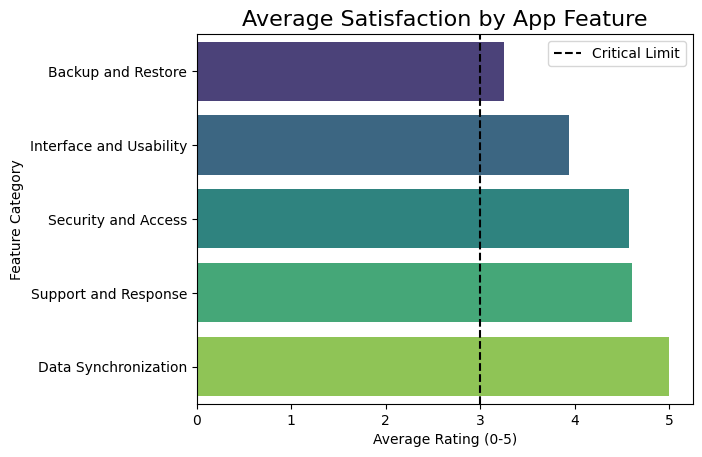

In [51]:
sns.barplot(x=category_stats['Average_Rating'], y = labels, palette="viridis") #color palette
#x being the rating and y being the index of features

plt.title('Average Satisfaction by App Feature', fontsize=16)
plt.xlabel('Average Rating (0-5)')
plt.ylabel('Feature Category')
plt.axvline(x=3, color='black', linestyle='--', label='Critical Limit')
plt.legend()
plt.show()

The analysis confirms the initial hypothesis: "Interface and Usability" is the strong point (Average 4.58), while "Backup and Restore" is the critical bottleneck (Average 3.25) with high negative engagement, indicating a serious problem.

Although "Data Synchronization" has a maximum average (5.00), it has only 1 review (no likes), being statistically irrelevant compared to the volume of other categories.

C:\Users\Jonas\AppData\Local\Temp\ipykernel_10608\2346481516.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_stats['Review_Count'], y= labels, palette="Blues_d")


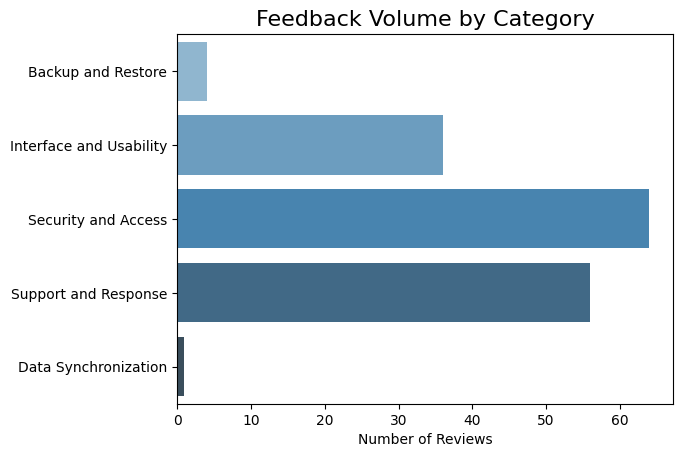

In [52]:
sns.barplot(x=category_stats['Review_Count'], y= labels, palette="Blues_d")
plt.title('Feedback Volume by Category', fontsize=16)
plt.xlabel('Number of Reviews')
plt.show()

The analysis confirms that Interface and Support are the great strengths of the application, with high averages and volume, but highlights Backup as the critical bottleneck: despite few reviews, it has the worst average (3.25) and the highest like-per-user ratio, evidencing a serious systemic data loss error.